<a href="https://colab.research.google.com/github/AdiA32/ImageAesthetic/blob/main/initial_playground_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notes on CLIP**
CLIP is like a smart robot that looks at pictures and reads words. It learns to match the pictures with the right words, so when you show it a new picture, it can tell you what's in the picture using the words it has learned.

Think of CLIP like a game of matching cards. On one side, you have lots of pictures of different things like cats, bikes, or trees. On the other side, you have words or sentences that describe these pictures.

CLIP plays this matching game millions of times with lots of picture-word pairs. It gets really good at figuring out which words go with which pictures. Even when it sees a new picture it has never seen before, it can make a really good guess about what words would match that picture because it has played the matching game so many times with other pictures and words.

*How is it different?*

CLIP is different from older machine learning models in a few key ways:

1. **Learning from Text and Images Together**: Older models usually needed separate training for images and text. CLIP learns from both at the same time, which helps it understand pictures by using descriptions in words.

2. **Versatility**: Before CLIP, if you wanted a model to recognize something in a picture, you often had to give it lots of examples of just that thing. CLIP can learn from all sorts of images and texts it finds, so it doesn't need specific examples to understand new things.

3. **Better Generalization**: Older models were often good at one task. CLIP is more flexible—it can do different things, like guessing what's in a picture or finding a picture that matches a description, without needing extra training for each task.

4. **Less Need for 'Labels'**: Usually, training an image model requires a lot of pictures that are labeled by humans (like telling the model "this is a cat" for thousands of pictures). CLIP can learn from pictures and their descriptions directly from the internet, which often don't need extra labeling.

So, CLIP is a bit like a child who learns words and what objects are just by looking at picture books and listening to stories, instead of having to be taught each word and object separately and in a more strict classroom setting.

# Text-to-Image and Image-to-image search Using CLIP

# Install libraries

In [ ]:
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [ ]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

# Image Exploration

## Load Data

In [ ]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "conceptual_captions", split="train",
    )

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

In [ ]:
image_data

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 3318333
})

We will select a sample of 300 images from this large number of images (3 318 333)

In [ ]:
image_data_df = pd.DataFrame(image_data[:100])

In [ ]:
image_data_df.shape

(100, 2)

In [ ]:
image_data_df.head()

,image_url,caption
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .


In [ ]:
#image_data_df.iloc[3]["caption"]

In [ ]:
"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise.
"""
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [ ]:
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [ ]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

,image_url,caption,is_valid
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True


In [ ]:
image_data_df.shape

(84, 3)

In [ ]:
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


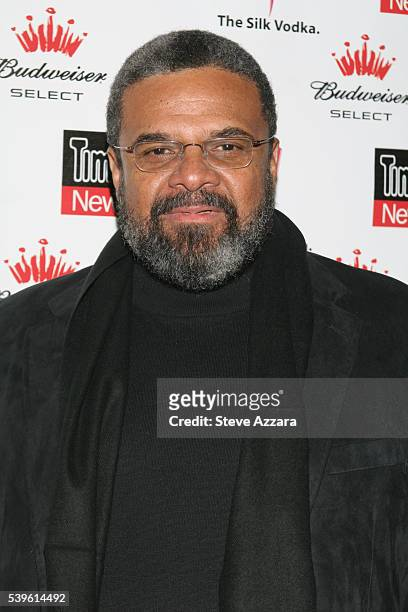

In [ ]:
image_data_df.iloc[10]["image"]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [ ]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [ ]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [ ]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [ ]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922298, -0.08825877, 0.020317122, -0.127..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.0041466653, 0.18943559, -0.123970345, 0.30..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28737974, -0.34814155, -0.042885188, 0.40..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.56064546, -0.1513804, -0.43740326, -0.3392..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035293028, 0.24262765, -0.12724704, -0.210..."


## Image Embeddings

In [ ]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

### Get the embedding of all the images

In [ ]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [ ]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [ ]:
image_data_df.head()

,image_url,caption,is_valid,image,text_embeddings,img_embeddings
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,True,<PIL.Image.Image image mode=RGB size=800x534 a...,"[[0.25922298, -0.08825877, 0.020317122, -0.127...","[[-0.003402032, -0.05358366, 0.35247523, 0.331..."
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,True,<PIL.Image.Image image mode=RGB size=500x441 a...,"[[0.0041466653, 0.18943559, -0.123970345, 0.30...","[[-0.25020307, -0.13257699, 0.09706208, 0.9788..."
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,True,<PIL.Image.Image image mode=RGB size=490x612 a...,"[[-0.28737974, -0.34814155, -0.042885188, 0.40...","[[-0.37446076, 0.2670178, -0.08697741, 0.31703..."
3,https://thumb1.shutterstock.com/display_pic_wi...,interior design of modern living room with fir...,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.56064546, -0.1513804, -0.43740326, -0.3392...","[[-0.16011232, -0.2958284, -0.113804005, -0.04..."
4,https://thumb1.shutterstock.com/display_pic_wi...,cybernetic scene isolated on white background .,True,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[0.035293028, 0.24262765, -0.12724704, -0.210...","[[0.18214405, 0.050188173, -0.64188564, -0.079..."


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values]
  list_captions = [top_images.iloc[idx].caption for idx in index_values]
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

# Perform Similarity Search: Cosine

## 1. Cosine Similarity Search

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [ ]:
image_data_df.columns

Index(['image_url', 'caption', 'is_valid', 'image', 'text_embeddings',
       'img_embeddings'],
      dtype='object')

### a. Text to image search

In [ ]:
query_caption = image_data_df.iloc[10].caption

top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: actor arrives for the premiere of the film


,index,caption,image,cos_sim
0,53,actor and daughters uk premiere held,<PIL.Image.Image image mode=RGB size=640x468 a...,0.272514
1,41,pop artist attends the 3rd annual at guest house,<PIL.Image.Image image mode=RGB size=490x612 a...,0.266114
2,16,actor attends the premiere of season,<PIL.Image.Image image mode=RGB size=499x612 a...,0.246037
3,30,actor arrives to the premiere,<PIL.Image.Image image mode=RGB size=444x612 a...,0.243593


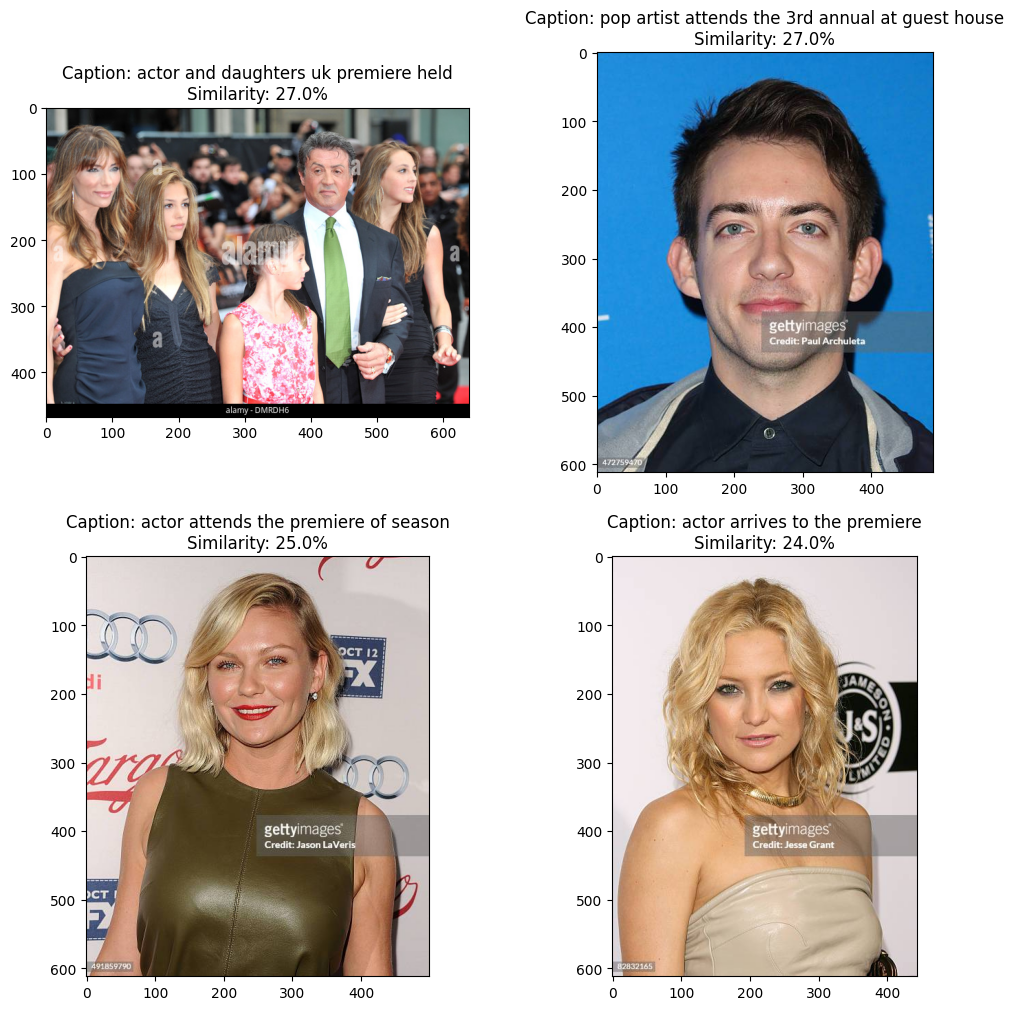

In [ ]:
plot_images_by_side(top_images)

### a. Image to image search

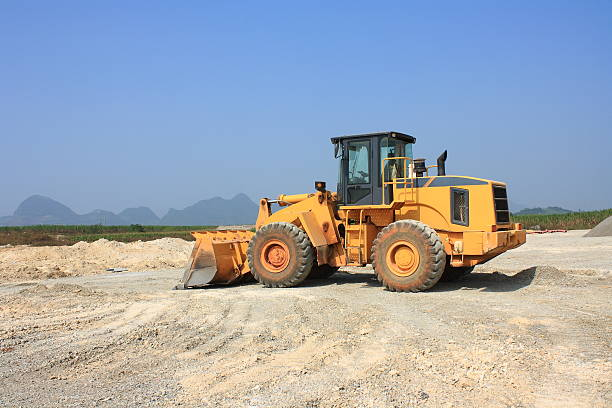

In [ ]:
query_image = image_data_df.iloc[55].image
query_image

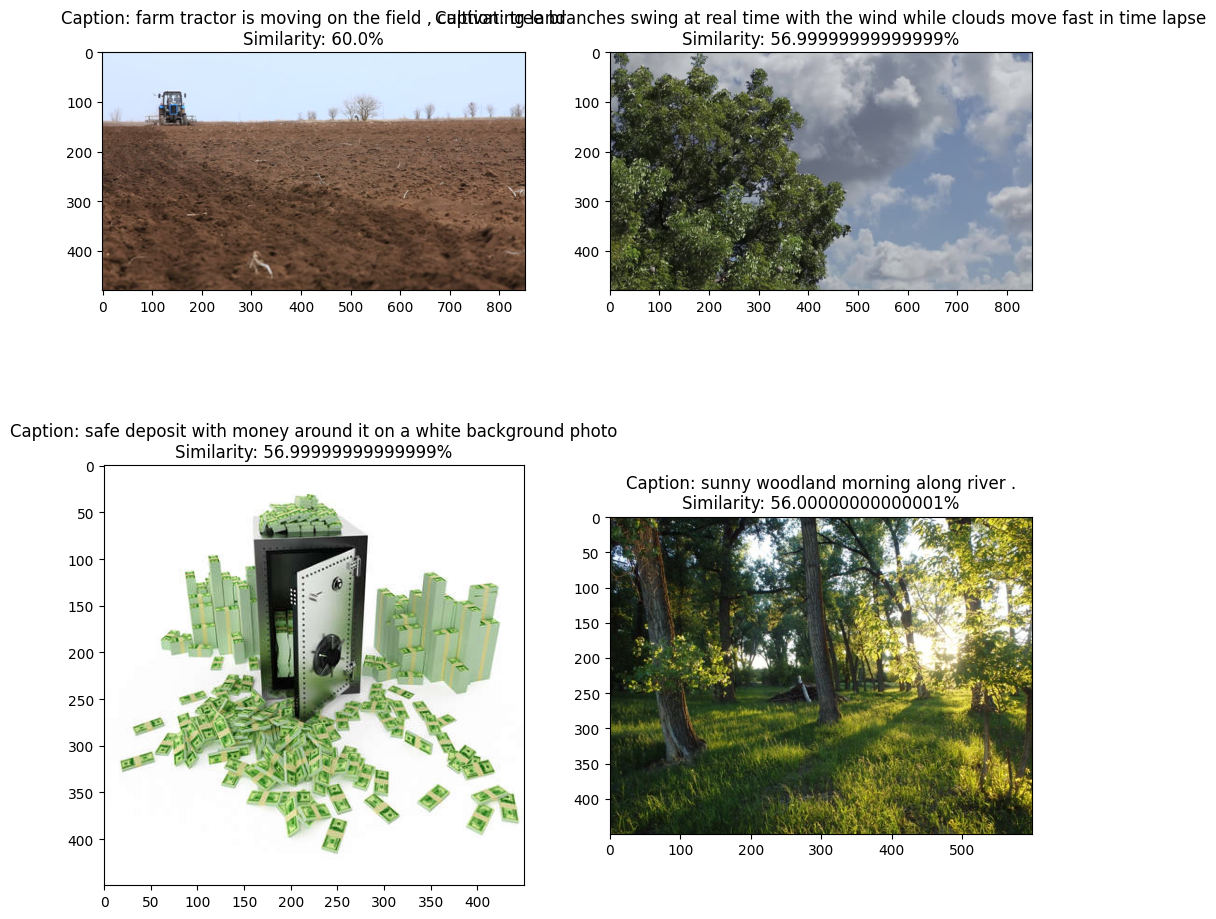

In [ ]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

## Facebook AI Similarity Search

# Approach n°2: Pinecone Client Library

## Configure the Pinecone Client

In [ ]:
import pinecone

Initialize connection to Pinecone and create index. [Get free API key](https://app.pinecone.io).

In [ ]:
pinecone.init(
    api_key = "<YOUR_API_KEY>",  # app.pinecone.io
    environment="us-west1-gcp"
)

my_index_name = "clip-image-search"
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name,
                        dimension=vector_dim,
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# Connect to the index
my_index = pinecone.Index(index_name = my_index_name)

UnauthorizedException: ignored

Now we can check the status of the vector data

In [ ]:
my_index.describe_index_stats()

## Prepare Vector

In [ ]:
image_data_df["vector_id"] = image_data_df.index
image_data_df["vector_id"] = image_data_df["vector_id"].apply(str)

# Get all the metadata
final_metadata = []

for index in range(len(image_data_df)):
  final_metadata.append({
      'ID':  index,
      'caption': image_data_df.iloc[index].caption,
      'image': image_data_df.iloc[index].image_url
  })

image_IDs = image_data_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()]

# Create the single list of dictionary format to insert
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# Upload the final data
my_index.upsert(vectors = data_to_upsert)

# Check index size for each namespace
my_index.describe_index_stats()

# Start the query

### Text to image

In [ ]:
text_query = image_data_df.iloc[10].caption
text_query

In [ ]:
# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

In [ ]:
# Run the query
my_index.query(query_embedding, top_k=4, include_metadata=True)

### Image to image

In [ ]:
image_query = image_data_df.iloc[43].image
image_query

In [ ]:
# Get the text embedding
query_embedding = get_single_image_embedding(image_query).tolist()

In [ ]:
# Run the query
my_index.query(query_embedding, top_k=4, include_metadata=True)

## Delete your index

Once finished with the index we can delete it to save resources.

In [ ]:
pinecone.delete_index(my_index_name)

---